# Slice S01E03 - Super store sales

The data is about Super Store sales. Contestants will use metadata about Super Store sales to predict profit. Each row is a product and volume of sales for a single product in a given store.

In [78]:
import pandas as pd 
import numpy as np 

train = pd.read_csv('train.csv')
train

,id,ship_mode,segment,country,city,state,postal_code,region,category,sub_category,sales,quantity,discount,profit
0,8522,Second Class,Consumer,United States,Everett,Massachusetts,2149,East,Office Supplies,Art,16.280,2,0.00,6.5120
1,7864,Standard Class,Corporate,United States,Los Angeles,California,90036,West,Furniture,Chairs,1684.752,6,0.20,210.5940
2,3522,Standard Class,Consumer,United States,New York City,New York,10035,East,Office Supplies,Storage,242.940,3,0.00,9.7176
3,8694,Standard Class,Consumer,United States,Los Angeles,California,90045,West,Office Supplies,Art,37.170,9,0.00,10.4076
4,2306,Second Class,Home Office,United States,San Francisco,California,94110,West,Furniture,Bookcases,1198.330,10,0.15,70.4900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168,6190,Standard Class,Home Office,United States,Escondido,California,92025,West,Office Supplies,Art,23.360,4,0.00,6.0736
7169,2967,Second Class,Consumer,United States,Richmond,Kentucky,40475,South,Office Supplies,Paper,9.420,3,0.00,4.2390
7170,418,Standard Class,Corporate,United States,East Point,Georgia,30344,South,Technology,Accessories,75.000,3,0.00,18.0000
7171,3998,Standard Class,Consumer,United States,Huntsville,Texas,77340,Central,Office Supplies,Binders,6.470,5,0.80,-9.7050


## Initial EDA

- Country is a useless column, all values are US. 
- Three major categories 'Office Supplies', 'Furniture', 'Technology' -- make sure to stratify
- 17 sub_categories, wonder how useful subcategories are for predicting product sales as opposed to actual product.
- Significant proportions in Consumer, Second Class and Office Supplies
- 5 regions, south particularly small

In [23]:
for c in ['ship_mode', 'segment', 'region', 'category', 'sub_category']:
    unique = train[c].unique()
    print(f'{c}({len(unique)}):')
    for u in unique:
        print(f'\t{u}: {len(train[train[c]==u])} {len(train[train[c]==u])/len(train):.2%}')

ship_mode(4):
	Second Class: 1422 19.82%
	Standard Class: 4285 59.74%
	First Class: 1095 15.27%
	Same Day: 371 5.17%
segment(3):
	Consumer: 3753 52.32%
	Corporate: 2156 30.06%
	Home Office: 1264 17.62%
region(4):
	East: 1687 23.52%
	West: 2425 33.81%
	Central: 2068 28.83%
	South: 993 13.84%
category(3):
	Office Supplies: 4353 60.69%
	Furniture: 1508 21.02%
	Technology: 1312 18.29%
sub_category(17):
	Art: 574 8.00%
	Chairs: 442 6.16%
	Storage: 611 8.52%
	Bookcases: 172 2.40%
	Furnishings: 664 9.26%
	Phones: 637 8.88%
	Binders: 1058 14.75%
	Envelopes: 189 2.63%
	Tables: 230 3.21%
	Accessories: 550 7.67%
	Paper: 1023 14.26%
	Fasteners: 152 2.12%
	Appliances: 342 4.77%
	Labels: 264 3.68%
	Supplies: 140 1.95%
	Machines: 78 1.09%
	Copiers: 47 0.66%


In [26]:
train.corr()['profit'].sort_values()

discount      -0.205416
postal_code   -0.087252
id            -0.003339
quantity       0.081564
sales          0.621893
profit         1.000000
Name: profit, dtype: float64

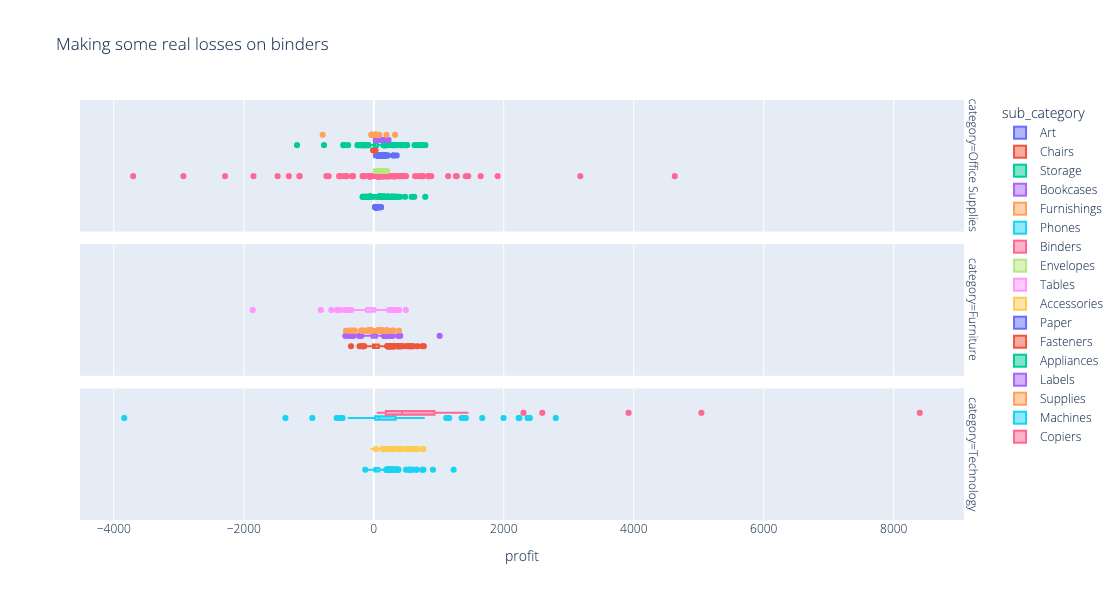

In [39]:
import plotly.express as px 

px.box(train, x='profit', color='sub_category', facet_row='category', height=600, title='Making some real losses on binders')

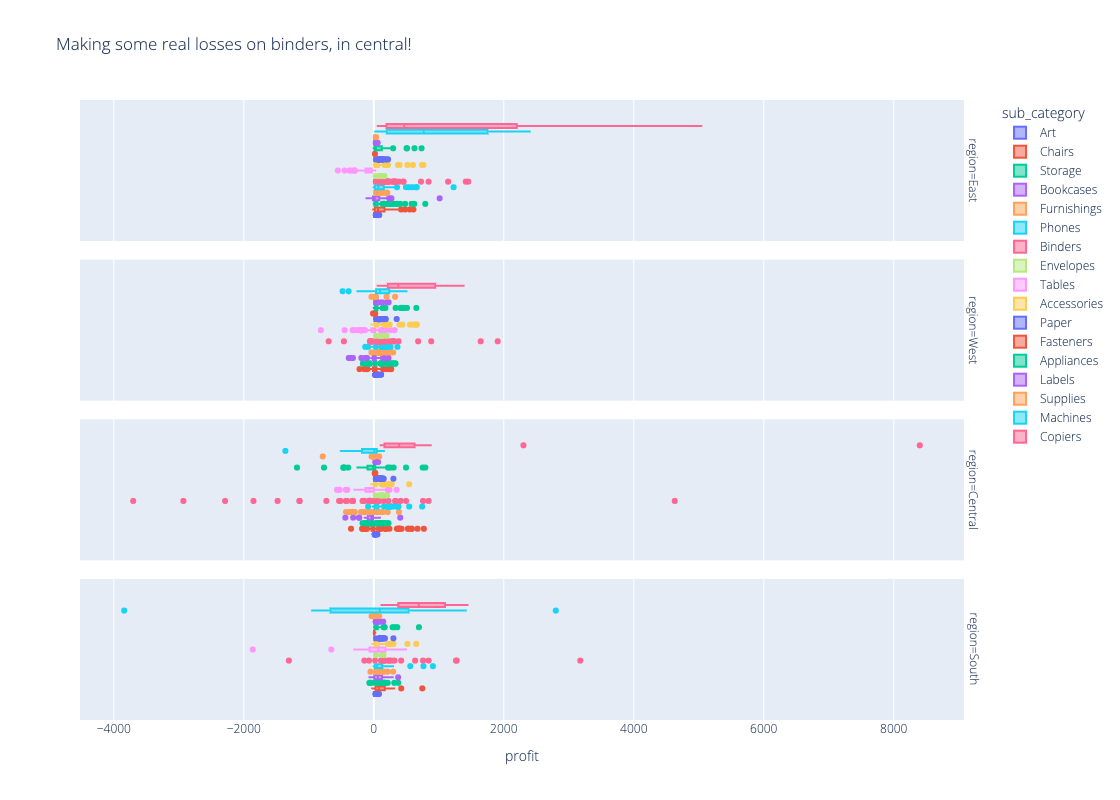

In [44]:
px.box(train, x='profit', color='sub_category', facet_row='region', height=800, title='Making some real losses on binders, in central!')

In [ ]:
central_binders = train.loc[(train['sub_category']=='Binders') & (train['region']=='Central'),:]
central_binders.sort_values('profit')

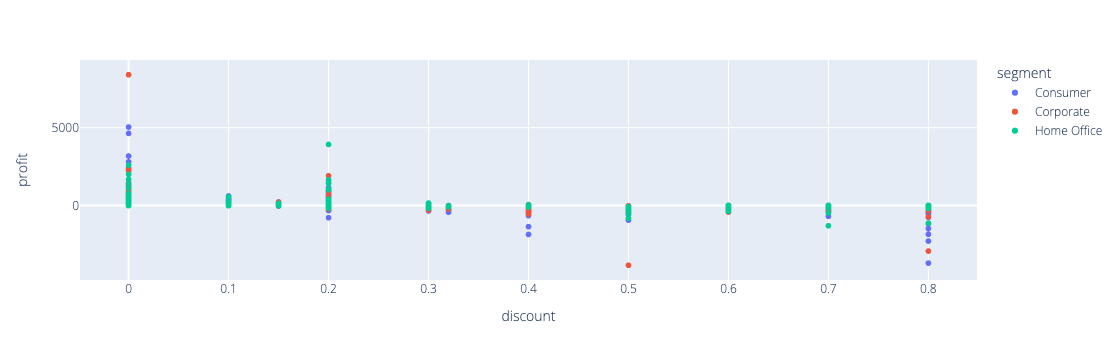

In [53]:
px.scatter(train, x='discount', y='profit', color='segment')

Looks like discounts above 30% result in a loss

In [223]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin

# Create transformation pipeline
numeric_cols = ['sales', 'quantity', 'discount']
categorical_cols = ['ship_mode', 'category', 'region', 'sub_category']

class add_everything_must_go_flag(BaseEstimator, TransformerMixin):
    
    def __init__(self, discount_threshold=0.31):
        self.discount_threshold=discount_threshold
        
    def fit(self, x, Y=None):
        return self
    
    def get_feature_names_out(self, input_features=None):
        return [f'>{self.discount_threshold}']
    
    def transform(self, x):
        return pd.DataFrame((x['discount']>self.discount_threshold).astype(int))
    
class region_state_city_average(BaseEstimator, TransformerMixin):
    
    def __init__(self, variable='sales', aggregate='mean'):
        self.variable=variable
        self.aggregate=aggregate
        
    def fit(self, x, Y=None):
        return self
    
    def get_feature_names_out(self, input_features=None):
        
        return [f'{c}_{self.aggregate}_{self.variable}' for c in ['region','state', 'city', 'subcategory', 'city_subcat', 'state_subcat']]
    
    def transform(self, x):
        region_avg_sales = x.groupby('region')[self.variable].transform(self.aggregate)
        state_avg_sales = x.groupby('state')[self.variable].transform(self.aggregate)
        city_avg_sales = x.groupby('city')[self.variable].transform(self.aggregate)
        sub_category_avg_sales = x.groupby('sub_category')[self.variable].transform(self.aggregate)
        city_subcat_avg_sales = x.groupby(['city','sub_category'])[self.variable].transform(self.aggregate)
        state_subcat_avg_sales = x.groupby(['state','sub_category'])[self.variable].transform(self.aggregate)
        
        return pd.concat([region_avg_sales, state_avg_sales, city_avg_sales, sub_category_avg_sales, 
                          city_subcat_avg_sales, state_subcat_avg_sales], axis=1)
        


column_transformer = ColumnTransformer([('everything_must_go', add_everything_must_go_flag(), ['discount']),
                                        ('discount_agg', region_state_city_average(variable='discount'), ['city', 'state', 'region','discount','sub_category']),
                                        ('sales_agg', region_state_city_average(variable='sales'), ['city', 'state', 'region','sales','sub_category']),
                                        ('quantity_agg', region_state_city_average(variable='quantity'), ['city', 'state', 'region','quantity','sub_category']),
                                        ('numeric', StandardScaler(), numeric_cols),
                
                                        ('categoric', OneHotEncoder(), categorical_cols)])

In [224]:
from sklearn.ensemble import RandomForestRegressor

x_train, y_train = train.drop('profit', axis=1), train['profit']
x_train_processed = column_transformer.fit_transform(x_train)

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(x_train_processed, y_train)

RandomForestRegressor(n_estimators=1000)

In [225]:
from sklearn.metrics import mean_squared_error

print(f'RMSE: {np.sqrt(mean_squared_error(y_train, rf_reg.predict(x_train_processed)))}')

RMSE: 38.494437539908155


In [226]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_, columns=['importance'], index=column_transformer.get_feature_names_out())
feature_importances.sort_values('importance', ascending=False)

,importance
numeric__sales,6.079706e-01
numeric__discount,6.031710e-02
discount_agg__state_subcat_mean_discount,5.951452e-02
sales_agg__city_subcat_mean_sales,4.817636e-02
sales_agg__state_subcat_mean_sales,4.557621e-02
discount_agg__city_subcat_mean_discount,2.619239e-02
sales_agg__subcategory_mean_sales,1.217399e-02
quantity_agg__state_subcat_mean_quantity,1.119397e-02
everything_must_go__>0.31,1.095551e-02
quantity_agg__city_mean_quantity,1.059398e-02


In [229]:
test = pd.read_csv('test.csv')
sub = pd.DataFrame(rf_reg.predict(column_transformer.transform(test)), index=test.id, columns=['profit'])
sub.to_csv('submission.csv')

In [235]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(loss_function='RMSE')
cb.fit(x_train_processed, y_train)

Learning rate set to 0.055896
0:	learn: 217.7956549	total: 54.1ms	remaining: 54s
1:	learn: 214.2455504	total: 56.1ms	remaining: 28s
2:	learn: 208.2436779	total: 57.6ms	remaining: 19.2s
3:	learn: 202.5820236	total: 59.4ms	remaining: 14.8s
4:	learn: 197.7335076	total: 61ms	remaining: 12.1s
5:	learn: 192.5499215	total: 62.7ms	remaining: 10.4s
6:	learn: 187.4619901	total: 64.4ms	remaining: 9.13s
7:	learn: 183.0679823	total: 66ms	remaining: 8.18s
8:	learn: 178.4167488	total: 67.6ms	remaining: 7.44s
9:	learn: 174.2420946	total: 69.1ms	remaining: 6.84s
10:	learn: 171.3314630	total: 70.7ms	remaining: 6.36s
11:	learn: 168.7070268	total: 72.3ms	remaining: 5.95s
12:	learn: 164.8142017	total: 73.9ms	remaining: 5.61s
13:	learn: 160.9970609	total: 75.7ms	remaining: 5.33s
14:	learn: 157.1709556	total: 77.1ms	remaining: 5.07s
15:	learn: 154.1906136	total: 78.7ms	remaining: 4.84s
16:	learn: 151.2055133	total: 80.1ms	remaining: 4.63s
17:	learn: 147.9296415	total: 81.7ms	remaining: 4.46s
18:	learn: 145.7

In [238]:
cb.get_best_score()

{'learn': {'RMSE': 19.404411417859933}}

In [241]:
pd.DataFrame(cb.predict(column_transformer.transform(test)), index=test.id, columns=['profit']).to_csv('submission.csv')

In [255]:
model=CatBoostRegressor(loss_function='RMSE')

grid = {'learning_rate': [0.1],
        'depth': [4],
        'l2_leaf_reg': [12,13,14,15]}

randomized_search_result = model.randomized_search(grid,
                                                   X=x_train_processed,
                                                   y=y_train,
                                                   plot=True,
                                                   verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 168.4336541	test: 355.7569960	best: 355.7569960 (0)	total: 4.41ms	remaining: 4.41s
1:	learn: 162.0792126	test: 349.4960948	best: 349.4960948 (1)	total: 8.42ms	remaining: 4.2s
2:	learn: 156.1408883	test: 344.5948686	best: 344.5948686 (2)	total: 12.9ms	remaining: 4.3s
3:	learn: 151.5534298	test: 339.7762564	best: 339.7762564 (3)	total: 18.1ms	remaining: 4.5s
4:	learn: 146.4456907	test: 334.7373380	best: 334.7373380 (4)	total: 21.9ms	remaining: 4.37s
5:	learn: 141.5462179	test: 329.5302534	best: 329.5302534 (5)	total: 25.2ms	remaining: 4.18s
6:	learn: 137.1204671	test: 325.1601862	best: 325.1601862 (6)	total: 28.2ms	remaining: 4s
7:	learn: 133.3664184	test: 320.3976621	best: 320.3976621 (7)	total: 32.4ms	remaining: 4.02s
8:	learn: 130.5307982	test: 316.2536603	best: 316.2536603 (8)	total: 35.5ms	remaining: 3.91s
9:	learn: 127.2022033	test: 312.1994168	best: 312.1994168 (9)	total: 37.8ms	remaining: 3.75s
10:	learn: 124.3157456	test: 308.4274224	best: 308.4274224 (10)	total: 40.8m

In [260]:
pd.DataFrame(model.predict(column_transformer.transform(test)), index=test.id, columns=['profit']).to_csv('submissions.csv')

In [256]:
model.get_params()

{'loss_function': 'RMSE', 'depth': 4, 'l2_leaf_reg': 12, 'learning_rate': 0.1}

In [262]:
feature_importances = pd.DataFrame(model.feature_importances_, columns=['importance'], index=column_transformer.get_feature_names_out())
feature_importances.sort_values('importance', ascending=False)

,importance
numeric__sales,45.231164
numeric__discount,9.381417
discount_agg__state_subcat_mean_discount,9.236768
sales_agg__state_subcat_mean_sales,4.805543
discount_agg__state_mean_discount,4.498047
sales_agg__subcategory_mean_sales,4.176325
discount_agg__city_subcat_mean_discount,3.176813
sales_agg__state_mean_sales,2.929182
discount_agg__subcategory_mean_discount,2.240974
quantity_agg__state_subcat_mean_quantity,2.106213
